# Importations 

In [1]:
!mkdir models

In [2]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  #advanced visualization library
import warnings
warnings.filterwarnings('ignore')

import time, gc 
import torch 
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing  
import transformers 
from tqdm.notebook import tqdm

from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
tqdm.pandas()

# Config 

In [3]:
seq_len = 24 
TRAIN_BATCH_SIZE =128
VALID_BATCH_SIZE =64
device = torch.device('cuda')

In [4]:
# usefull class 
class AverageMeter:
    """
    Computes and stores the average and current value
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


# Data Loading

In [5]:
data = pd.read_csv('../input/chicago-traffic/chicago.csv')
data["TIME"]=pd.to_datetime(data["TIME"], format="%m/%d/%Y %H:%M:%S %p")
data.drop(data[data['SPEED']==0].index,inplace =True)
data = data[data['SPEED']<100]
data['day'] = data['TIME'].dt.day
data['MONTH'] = data['TIME'].dt.month
data['YEAR'] = data['TIME'].dt.year
data = data.groupby(['REGION_ID','HOUR','MONTH','day', 'WEST','EAST', 'SOUTH','NORTH','DAY_OF_WEEK','YEAR'])[['SPEED','BUS_COUNT','NUM_READS']].agg('mean').reset_index()
data['CENTER_LAT']=data['NORTH']*0.5+0.5*data['SOUTH']
data['CENTER_LON']=data['EAST']*0.5+0.5*data['WEST']

## Feature engineering

In [6]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [7]:
def width(x) : 
    return haversine_array(x['NORTH'],x['WEST'],x['NORTH'],x['EAST'])
def length(x) : 
    return haversine_array(x['NORTH'],x['EAST'],x['SOUTH'],x['EAST'])

In [8]:
data['length'] =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(length,axis=1)
data['width']  =  data[['WEST','EAST', 'SOUTH','NORTH']].progress_apply(width,axis=1)

In [9]:
data['area'] = data['length']*data['width']
data['reders_per_area'] = data['BUS_COUNT']/data['area'] 
data['READS_per_area'] = data['NUM_READS']/data['area'] 
data['BUS_ratio'] = data['BUS_COUNT']/data['NUM_READS'] 

## Data preprocessing

In [10]:
categorical_features = ['REGION_ID','MONTH','HOUR','day','DAY_OF_WEEK','YEAR']
LSTM = ['HOUR','DAY_OF_WEEK']
Numerical_features = ['NUM_READS','BUS_COUNT','area','length','width','CENTER_LAT','CENTER_LON','reders_per_area','READS_per_area','BUS_ratio']

In [11]:
from sklearn.preprocessing import StandardScaler
for i in Numerical_features : 
    scalar=StandardScaler()
    scalar.fit(data[i].values.reshape(-1, 1))
    data[i]=scalar.transform(data[i].values.reshape(-1, 1)) 

In [12]:
data['MINUTE'] = '00'
data['Time'] = pd.to_datetime(data[['YEAR','MONTH','day','HOUR','MINUTE']].astype(str).agg('-'.join,axis=1),format='%Y-%m-%d-%H-%M')

# Entity embeddings hyperparametres tuning 

In [13]:
def get_emb_dim(df,categorical,LSTM):
    output=[]
    for categorical_var in categorical:

      cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'

      no_of_unique_cat  = df[categorical_var].nunique()
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 12))
      output.append((no_of_unique_cat,embedding_size))    
      print('Categorica Variable:', categorical_var,
          'Unique Categories:', no_of_unique_cat,
          'Embedding Size:', embedding_size)
    output_lstm = []
    for categorical_var in LSTM :

        cat_emb_name= categorical_var.replace(" ", "")+'_Embedding'

        no_of_unique_cat  = df[categorical_var].nunique()
        embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 12))
        output_lstm.append((no_of_unique_cat,embedding_size))    
      
    return output,output_lstm

In [14]:
emb_size , lstm_emb = get_emb_dim(data,categorical_features,LSTM)

Categorica Variable: REGION_ID Unique Categories: 29 Embedding Size: 12
Categorica Variable: MONTH Unique Categories: 12 Embedding Size: 6
Categorica Variable: HOUR Unique Categories: 24 Embedding Size: 12
Categorica Variable: day Unique Categories: 31 Embedding Size: 12
Categorica Variable: DAY_OF_WEEK Unique Categories: 7 Embedding Size: 4
Categorica Variable: YEAR Unique Categories: 3 Embedding Size: 2


In [15]:
for f in categorical_features : 
  label_encoder = preprocessing.LabelEncoder()
  label_encoder.fit(data[f].astype('str'))
  data[f] = label_encoder.transform(data[f].astype('str').fillna('-1'))

# Engine 

In [16]:
def loss_fn(outputs, targets):
    return nn.MSELoss()(outputs, targets)

In [17]:
def train_fn(data_loader, model, optimizer, scheduler):
    model.train()
    tr_loss = 0 
    counter = 0 
    
    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    for bi, d in tk0 :
        
        targets = d["SPEED"]
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(d)
  
        loss = loss_fn(outputs, targets.view(-1,1))
        tr_loss += loss.item()
        counter +=1 
        loss.backward()
        optimizer.step()
        
        losses.update(loss.item(), targets.size(0))
        rmse.update(np.sqrt(loss.item()), targets.size(0))
        tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
    return tr_loss/counter

In [18]:
def eval_fn(data_loader, model):
    model.eval()
    fin_loss = 0
    counter = 0
    
    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))
    
    with torch.no_grad():
        
        for bi, d in tk0 :
            
            targets = d["SPEED"]
            targets = targets.to(device, dtype=torch.float)
            outputs = model(d)

            loss = loss_fn(outputs, targets.view(-1,1))
            fin_loss +=loss.item()
            counter += 1
            
            losses.update(loss.item(), targets.size(0))
            rmse.update(np.sqrt(loss.item()), targets.size(0))
            tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
        
        return fin_loss/counter 

In [19]:
def predict(model,data_loader) : 
    model.eval()
    
    
    losses = AverageMeter()
    rmse=  AverageMeter()
    tk0 = tqdm(enumerate(data_loader), total=len(data_loader))

    with torch.no_grad():
        
        for bi, d in tk0 :
            
            targets = d["SPEED"]
            targets = targets.to(device, dtype=torch.float)
            outputs = model(d)

            loss = loss_fn(outputs, targets.view(-1,1))
            
            if bi==0 : 
                out = outputs 
            else : 
                out = torch.cat([out,outputs],dim = 0 )
            
            losses.update(loss.item(), targets.size(0))
            rmse.update(np.sqrt(loss.item()), targets.size(0))
            tk0.set_postfix(loss=losses.avg, RMSE=rmse.avg)
        
        return out.cpu().detach().numpy() 
    

In [20]:
def run(model,EPOCHS):
    
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=8
    )
    
    
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )

    


    num_train_steps = int(len(train_data_loader)) * EPOCHS
    optimizer = AdamW(model.parameters(), lr=1e-2)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )
    train_loss =  []
    val_loss = []
    for epoch in range(EPOCHS):
        print(f'--------- Epoch {epoch} ---------')
        tr_loss=train_fn(train_data_loader, model, optimizer, scheduler)
        train_loss.append(tr_loss)
        print(f" train_loss  = {np.sqrt(tr_loss)}")

        
        val = eval_fn(valid_data_loader, model)
        val_loss.append(val)
        print(f" val_loss  = {np.sqrt(val)}")
        torch.save(model.state_dict(), 'models/model_rnn.bin')

        scheduler.step()
    return val_loss,train_loss

## Dataset class

In [21]:
def series_to_supervised(data, n_in=1, n_out=1, col=[], dropnan=True):
    
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in col]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in col]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in col]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
df = pd.DataFrame()

for i in tqdm( data.REGION_ID.unique() , total = len(data.REGION_ID.unique())):
     
    sub_set = data[categorical_features+Numerical_features+['SPEED','Time']]
    sub_set = sub_set.sort_values('Time',ascending=False)
    sub_set = sub_set[sub_set['REGION_ID']==i]
    sub_set = series_to_supervised(sub_set,seq_len,1,sub_set.columns.tolist())
    df = df.append(sub_set,ignore_index = True )
    
    
df.shape

(501434, 450)

In [23]:
class dataset() : 
    
    def __init__( self , data, categorical_features , Numericla_features ,window_size) : 
        
        self.window_size = window_size   
        self.df = data
        self.categorical = categorical_features
        self.Numeric = Numericla_features
        out = dict()
        
        for i in self.categorical : 
            col = [ '%s(t)' % i ] 
            out[i] = torch.tensor( self.df[col].values , dtype=torch.long )
        
        for i in self.Numeric : 
            col = [ '%s(t)' % i ] 
            out[i] = torch.tensor( self.df[col].values , dtype=torch.float )
        old = []
        for i in LSTM+['SPEED'] : 
            col = [('%s(t-%d)' % (i, j)) for j in range(self.window_size, 0, -1)] 
            if i == 'SPEED' : 
                out[i+'_(t-k)'] =  torch.tensor( self.df[col].values , dtype=torch.float )
            else : 
                out[i+'_(t-k)'] =  torch.tensor( self.df[col].values , dtype=torch.long )
            old.append(i+'_(t-k)')
        self.old = old
            
        out['SPEED'] = torch.tensor(self.df['SPEED(t)'].values ,dtype=torch.float ) 
        self.df = out
        
    def __len__(self) : 
        
        return len(self.df['SPEED'])
    
    def __getitem__(self,item) : 
        
        out = dict()
        
        for i in self.categorical : 
            out[i] = torch.tensor( self.df[i][item] , dtype=torch.long )
        
        for i in self.Numeric : 
            out[i] = torch.tensor( self.df[i][item] , dtype=torch.float )
        
        for i in self.old : 
            if i == 'SPEED_(t-k)':
                out[i] = torch.tensor( self.df[i][item] , dtype=torch.float )
            else : 
                out[i] = torch.tensor( self.df[i][item] , dtype=torch.long )
        
        out['SPEED'] = torch.tensor(self.df['SPEED'][item],dtype=torch.float ) 
        
        return out


## The Network Architecture


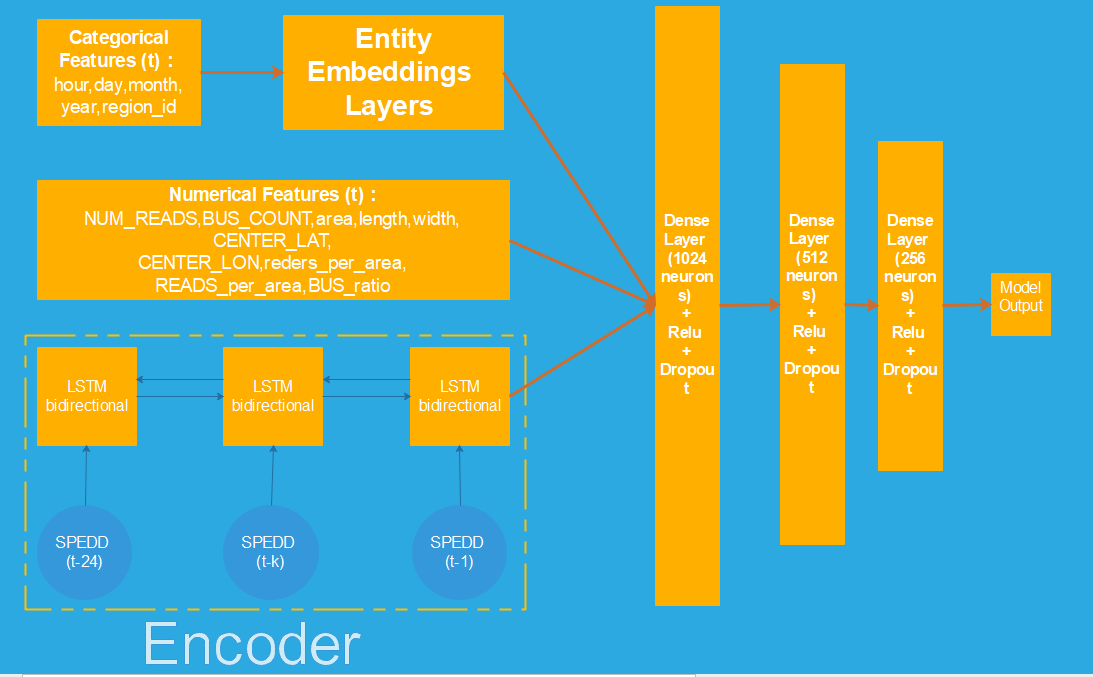

In [24]:
import math
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, a=math.sqrt(3))

In [25]:
class Seq2SeqRnn(nn.Module):
    
    def __init__(self,cat,num,emb_size ,lstm_emb, hidden_size ):
        
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size=1
        self.numerical =num 
        self.cat = cat 
        self.emb_size = emb_size 
        
        
        outputs_cat = nn.ModuleList()
        
        for inp , emb  in emb_size :
            embedding_layer = nn.Embedding(inp+2,emb)
            outputs_cat.append(embedding_layer)
        self.outputs_cat = outputs_cat 
        
        outputs_cat = nn.ModuleList()
        for inp , emb  in lstm_emb :
            embedding_layer = nn.Embedding(inp+2,emb)
            outputs_cat.append(embedding_layer)
        self.lstm_emb = outputs_cat 
        
        
        n_emb = sum([e[1] for e in self.emb_size])
        n_emb_lstm = sum([e[1] for e in lstm_emb])
        self.input_size = n_emb_lstm + 1
        self.rnn = nn.GRU(input_size= self.input_size , hidden_size=hidden_size, num_layers=1, 
                           bidirectional=True, batch_first=True)
        
        
        self.fc = nn.Sequential(  
                              nn.Linear( n_emb + len(num) + hidden_size*2 ,1024),
                              nn.BatchNorm1d(1024),
                              nn.Dropout(0.5),
                              nn.ReLU(),
                              nn.Linear(1024,512),
                              nn.BatchNorm1d(512),
                              nn.Dropout(0.3),
                              nn.ReLU(),
                              nn.Linear(512,256),
                              nn.BatchNorm1d(256),
                              nn.Dropout(0.2),
                              nn.ReLU(),
                              nn.Linear(256,1)
    )
        self.fc.apply(init_normal)
           
    
        
        
    def forward(self, data ):
        
        cat_lstm = []
        for i in range(len(self.lstm_emb)) : 
            inputs = data[LSTM[i]+'_(t-k)'].to(device,dtype=torch.long) 
            out = self.lstm_emb[i](inputs)
            cat_lstm.append(out) 

        x_lstm = torch.cat(cat_lstm,dim= 2 )
        x_speed = data['SPEED_(t-k)'].to(device,dtype=torch.float) 
        x_speed = x_speed.unsqueeze(2)
        x_lstm = torch.cat([x_lstm,x_speed],dim= 2 )
        out , hid = self.rnn(x_lstm)
        x_lstm = torch.cat([hid[0],hid[1]],dim=1)
        
        
        outputs_emb = [] 
        for i in range(len(self.cat)) : 
            inputs = data[self.cat[i]].to(device,dtype=torch.long) 
            out = self.outputs_cat[i](inputs)
            outputs_emb.append(out.squeeze(1)) 

        x_cat = torch.cat(outputs_emb,dim= 1)

        output_num = []

        for i in self.numerical : 
            inputs = (data[i].view(-1,1)).to(device,dtype=torch.float)
            output_num.append(inputs)
        
        x_num = torch.cat(output_num,dim=1)


        x_all = torch.cat([x_num,x_cat,x_lstm],dim=1) 
        x_final = self.fc(x_all)
        return x_final

## Train Test Validation split

In [26]:
df_train ,df_test   = model_selection.train_test_split( df ,test_size = 0.1 ,random_state = 44  )
df_train , df_valid = model_selection.train_test_split( df_train ,test_size = 0.2 ,random_state = 44  )

## Training 

In [27]:
gc.collect()

3

In [28]:
start_time = time.time()
train_dataset = dataset(
        df_train,categorical_features,Numerical_features,seq_len
    )

valid_dataset = dataset(
        df_valid,
        categorical_features,
        Numerical_features,seq_len

)
model=Seq2SeqRnn(cat = categorical_features,num = Numerical_features, emb_size = emb_size , hidden_size=64,lstm_emb =lstm_emb )
model.load_state_dict(torch.load('../input/model3/models/model_rnn.bin', map_location="cuda:0"))
model = model.to(device)
    
getattr(tqdm, '_instances', {}).clear()
val_loss,tr_loss = run(model,40)

--------- Epoch 0 ---------



 train_loss  = 1.3255191496233774



 val_loss  = 1.2130840041751507
--------- Epoch 1 ---------



 train_loss  = 1.3244651698968812



 val_loss  = 1.19514385172369
--------- Epoch 2 ---------



 train_loss  = 1.321066137859962



 val_loss  = 1.2025925084827906
--------- Epoch 4 ---------



 val_loss  = 1.2103415956546557
--------- Epoch 12 ---------



 train_loss  = 1.3007154804359697



 val_loss  = 1.2305946841381086
--------- Epoch 15 ---------



 val_loss  = 1.2071716786494247
--------- Epoch 29 ---------



 train_loss  = 1.2756643559923173


In [29]:
print("total training time is %s Minute " %(118.0+((time.time() - start_time)/60)))
print("hardware : NVidia K80 GPUs ")

total training time is 236.43169556856157 Minute 
hardware : NVidia K80 GPUs 


## Model evalutation

In [30]:
test_dataset = dataset(
        df_test , categorical_features , Numerical_features , seq_len
    )
test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )
val = eval_fn(test_data_loader, model)
print(f" TEST RMSE = {np.sqrt(val)}")


 TEST RMSE = 1.1782466823355298


In [31]:
def plot(region , year , month , day ) : 
    df['year']  = df['Time(t)'].dt.year
    df['month'] = df['Time(t)'].dt.month
    df['days']  = df['Time(t)'].dt.day
    sub_plot = df[(df['REGION_ID(t)']==region)&(df['year']==year)&(df['month']==month)& (df['days']<day)]
    sub_plot = sub_plot.sort_values('Time(t)')
    y=  sub_plot['SPEED(t)'].values
    x_data = dataset(
        sub_plot , categorical_features , Numerical_features , seq_len
    ) 
    x_data_loader = torch.utils.data.DataLoader(
        x_data,
        batch_size=VALID_BATCH_SIZE,
        num_workers=4
    )
    predictions  =predict(model,x_data_loader).reshape(1,-1)[0]
    plt.figure(figsize=(24, 8))
    plt.plot(sub_plot['Time(t)'].values , sub_plot['SPEED(t)'].values, '--',label = 'real values')
    plt.plot(sub_plot['Time(t)'].values , predictions,label = 'predicted values')
    plt.ylabel(f'SPEED in region id {region}')
    plt.title(f' predicted vs real values ')
    plt.xlabel('Time')
    plt.grid(True)
    plt.legend()

    plt.show()

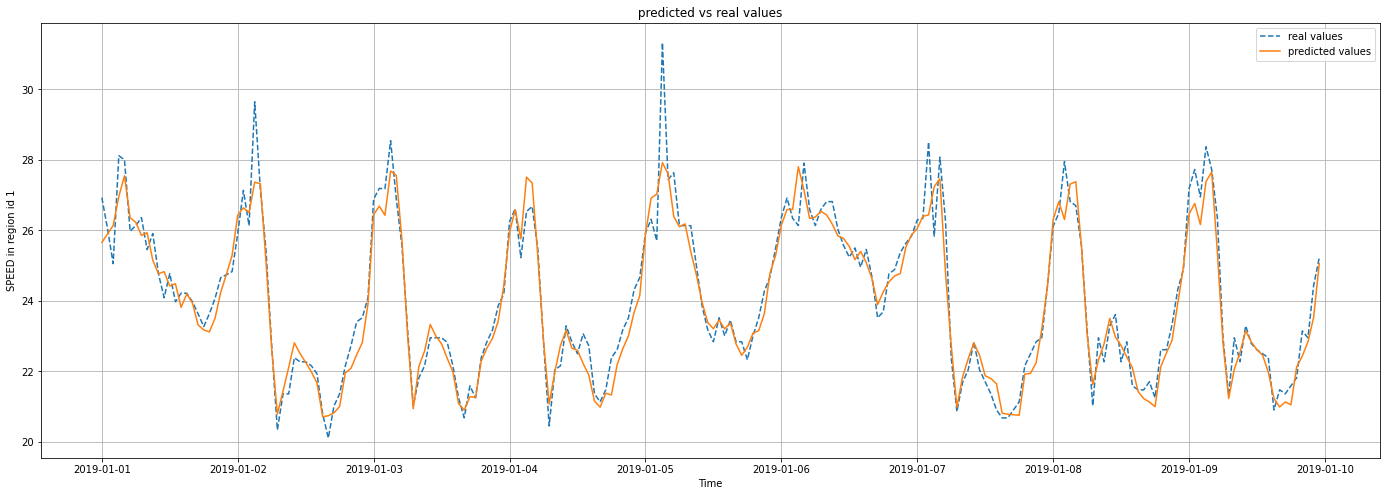

In [32]:
plot(1,2019,1,10)

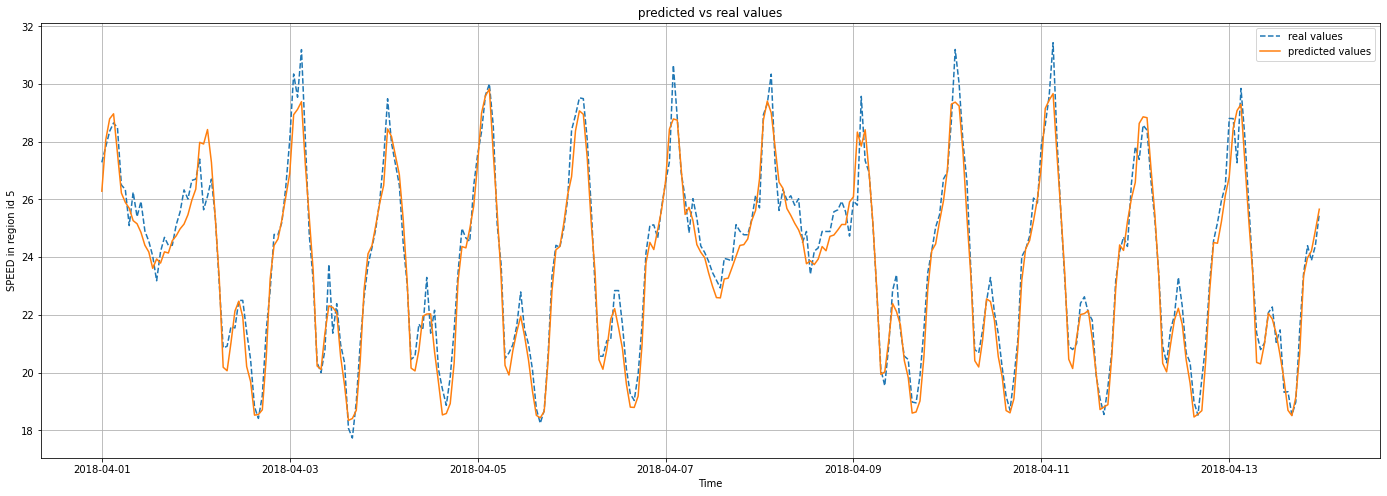

In [33]:
plot(5,2018,4,14)

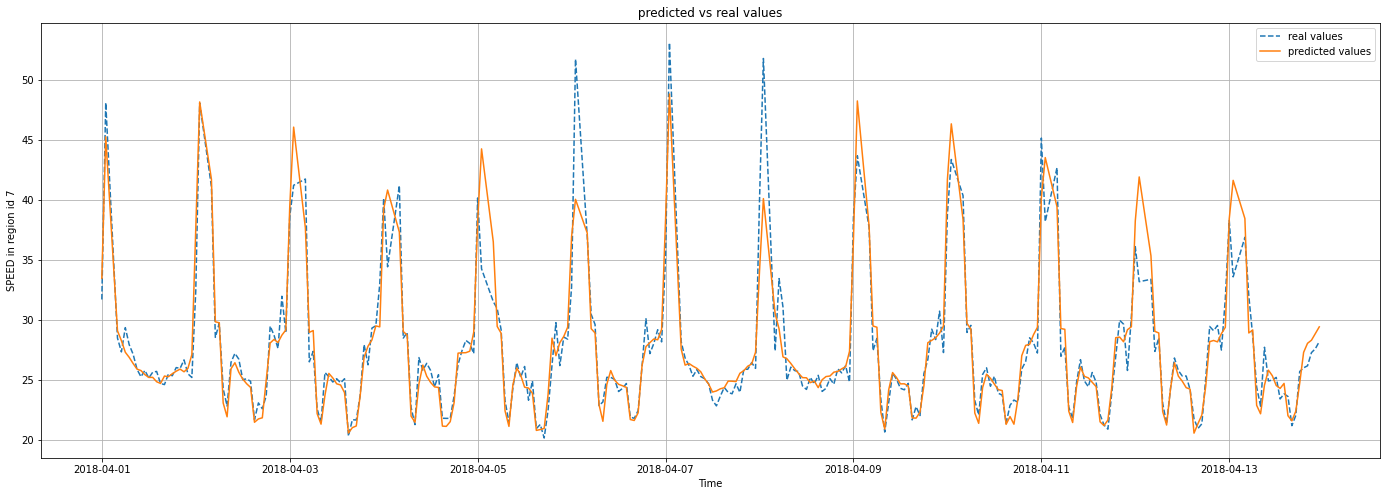

In [34]:
plot(7,2018,4,14)


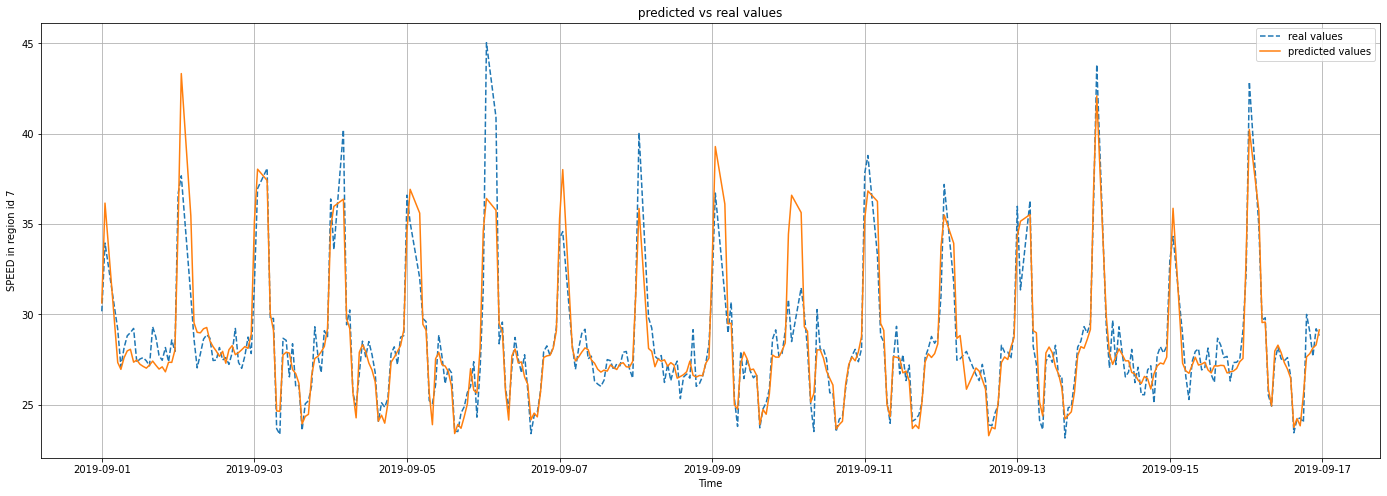

In [35]:
plot(7,2019,9,17)
